# Batch learning and evaluation scripts demo

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib

In [3]:
import matplotlib
import matplotlib.pyplot
import cartopy.crs as ccrs


In [4]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [5]:
from dataexploration.xbt_dataset import XbtDataset
import dataexploration.xbt_dataset
from classification.imeta import imeta_classification
from classification import classification

In [6]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [7]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}


In [8]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [9]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [10]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name)

In [11]:
json_params_path = os.path.join(root_repo_dir, 'examples', 'xbt_param_decisionTree_country.json')

In [43]:
exp2_cv = classification.ClassificationExperiment(json_params_path, xbt_input_dir, xbt_output_dir)

In [44]:
%%time
results_cv, classifiers_cv = exp2_cv.run_cvhpt_experiment()

loading dataset
generating splits
creating hyperparameter tuning objects
running cross validation
calculating metrics
exporting classifier objects through pickle
CPU times: user 16min 48s, sys: 25.1 s, total: 17min 13s
Wall time: 58min 57s


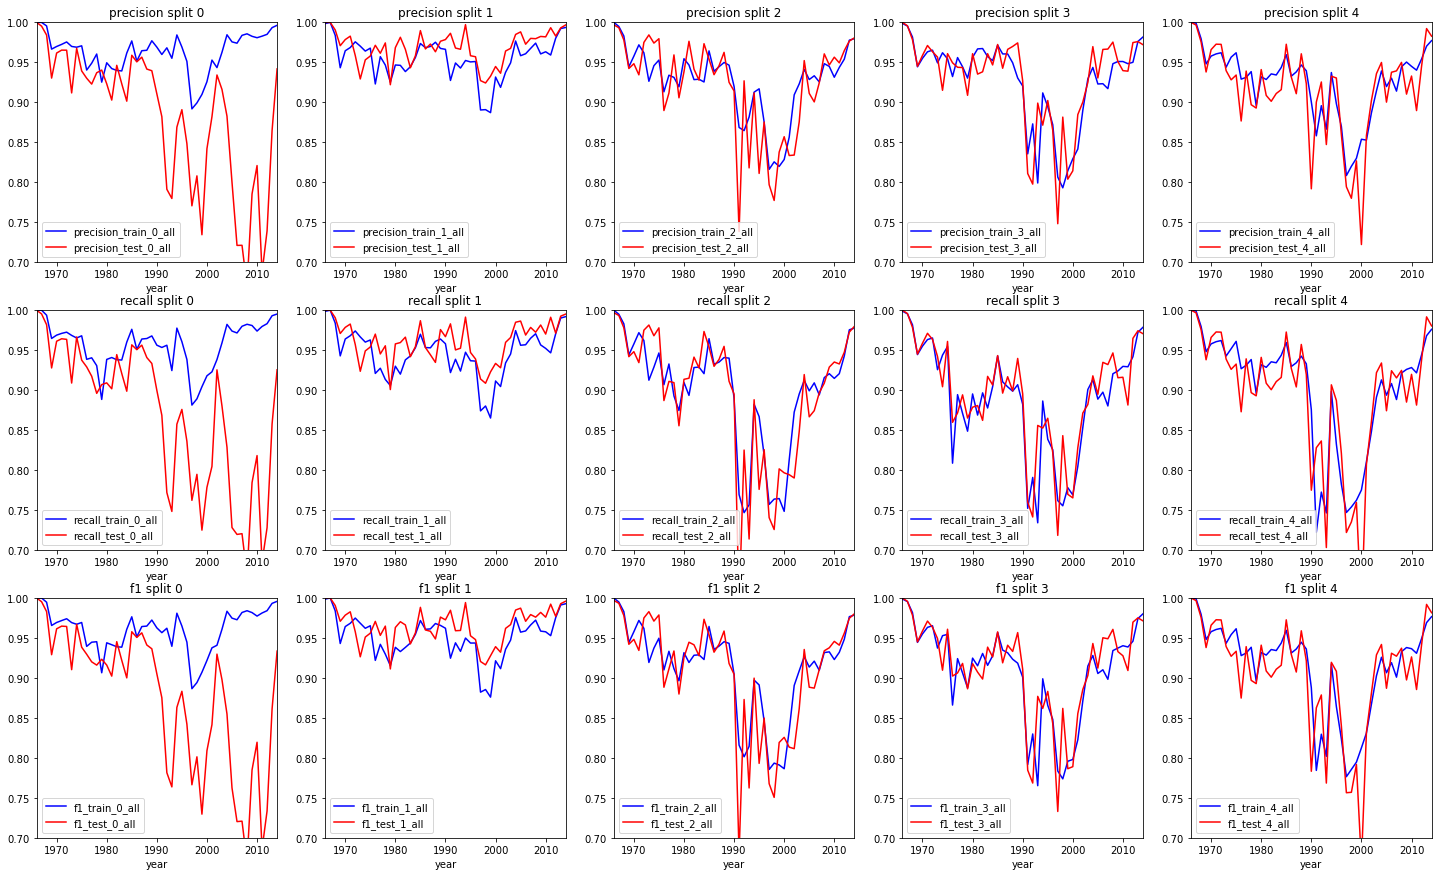

In [45]:
fig_results = matplotlib.pyplot.figure('xbt_results',figsize=(25,15))
for label1, metrics1  in classifiers_cv.items():
    ax_precision = fig_results.add_subplot(3,5,label1 +1, title='precision split {0}'.format(label1))
    ax_recall = fig_results.add_subplot(3,5,label1 + 1 + 5 * 1, title='recall split {0}'.format(label1))
    ax_f1 = fig_results.add_subplot(3,5,label1 + 1 + 5 * 2, title='f1 split {0}'.format(label1))
    results_cv.plot.line(ax=ax_precision, x='year', y=[f'precision_train_{label1}_all',f'precision_test_{label1}_all'], color=['b', 'r'], ylim=(0.7,1.0))
    results_cv.plot.line(ax=ax_recall, x='year', y=[f'recall_train_{label1}_all',f'recall_test_{label1}_all'], color=['b', 'r'], ylim=(0.7,1.0))
    results_cv.plot.line(ax=ax_f1, x='year', y=[f'f1_train_{label1}_all',f'f1_test_{label1}_all'], color=['b', 'r'], ylim=(0.7,1.0))

### Analysis 
***Under construction***